In [96]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader
from torchvision import transforms

import os

# MLP layer

In [31]:

# Hyperparameters
input_size = 32  # Number of input features
hidden_size = 2  # Number of neurons in the hidden layer
output_size = 1  # Number of output neurons (assuming a regression problem)

num_epochs = 5
learning_rate = 0.01


In [103]:
# Create the neural network
class Net(nn.Module):
    def __init__(self):
        #super(Net, self).__init__()
        super().__init__()
        # The last layer must have as many outputs as classes in the dataset!
        # Each target - cat, truck, airplane, etc - goes into its separate output!
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(32 * 32 * 3, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 100)
                                    )


        #self.fc1 = nn.Linear(input_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        #x = self.fc1(x)
        #x = self.fc2(x)
        return self.layers(x)


In [106]:
# Set fixed random number seed
torch.manual_seed(42)

# Prepare CIFAR-10 dataset
dataset = CIFAR100(os.getcwd(), download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True, num_workers=1)

Files already downloaded and verified


In [107]:
# Initialize the neural network instance
net = Net()

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    loss_per_epoch = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get inputs
        inputs, targets = data

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Calculate loss
        loss = loss_function(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimization
        optimizer.step()

        # Print progress
        loss_per_epoch += loss.item()
        if i % 500 == 499:
                    print('Loss after mini-batch %5d: %.3f' %
                            (i + 1, loss_per_epoch / 500))
                    # Reset loss after mini-batch
                    loss_per_epoch = 0.0


# Process is complete.
print('Training process has finished.')


Starting epoch 1
Loss after mini-batch   500: 4.650
Loss after mini-batch  1000: 4.612
Loss after mini-batch  1500: 4.612
Loss after mini-batch  2000: 4.612
Loss after mini-batch  2500: 4.611
Starting epoch 2
Loss after mini-batch   500: 4.611
Loss after mini-batch  1000: 4.612
Loss after mini-batch  1500: 4.611
Loss after mini-batch  2000: 4.612
Loss after mini-batch  2500: 4.612
Starting epoch 3
Loss after mini-batch   500: 4.611
Loss after mini-batch  1000: 4.612
Loss after mini-batch  1500: 4.611
Loss after mini-batch  2000: 4.611
Loss after mini-batch  2500: 4.612
Starting epoch 4
Loss after mini-batch   500: 4.611
Loss after mini-batch  1000: 4.612
Loss after mini-batch  1500: 4.611
Loss after mini-batch  2000: 4.612
Loss after mini-batch  2500: 4.612
Starting epoch 5
Loss after mini-batch   500: 4.612
Loss after mini-batch  1000: 4.611
Loss after mini-batch  1500: 4.612
Loss after mini-batch  2000: 4.611
Loss after mini-batch  2500: 4.611
Training process has finished.


In [84]:
# Make predictions
with torch.no_grad():
    new_input = torch.randn(1, 3, 32, 32)
    predicted_output = net(new_input)
    print("Predicted output:", predicted_output)

Predicted output: tensor([[-13.5783,  -9.6823, -12.0806,  -0.6509,  -8.8602,  -8.8664,  -3.3945,
         -17.8990, -12.7768, -16.9954]])


# Custom linear

In [18]:
class CustomLinear(nn.Module):
    def __init__(self, input_size, output_size, num_connections):
        super(CustomLinear, self).__init__()
        self.linear_layers = nn.ModuleList([nn.Linear(input_size, output_size) for _ in range(num_connections)])

    def forward(self, x):
        outputs = []
        for layer in self.linear_layers:
            outputs.append(layer(x))
            
        return torch.stack(outputs, dim=1)

# Attention layer

In [17]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.shape[-1]))
        attention_weights = self.softmax(attention_scores)

        output = torch.matmul(attention_weights, value)
        return output

class SelfAttentionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SelfAttentionNet, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.attention(x)
        x = self.fc(x)
        return x

In [18]:
# Create an instance of the SelfAttentionNet
model = SelfAttentionNet(input_dim=10, hidden_dim=32, output_dim=5)

# Sample input data
input_data = torch.randn(16, 10)

# Forward pass
output = model(input_data)

# Combining both

In [ ]:
class SelfAttentionMLP(nn.Module):
    def __init__(self, input_size, hidden_size=2):
        super(SelfAttentionMLP, self).__init__()

        # Fixed MLP layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Freeze MLP weights to prevent backpropagation
        for param in self.parameters():
            param.requires_grad = False

        # Self-attention layer
        self.attention = nn.Linear(input_size, 1)

    def forward(self, x):
        
        # Calculate attention scores
        attention_scores = self.attention(x)
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Apply attention to the input
        attended_input = x * attention_weights

        # Pass through the MLP
        hidden1 = self.fc1(attended_input)
        hidden2 = self.fc2(hidden1)

        return hidden2

# Network visualization

https://www.appsilon.com/post/visualize-pytorch-neural-networks

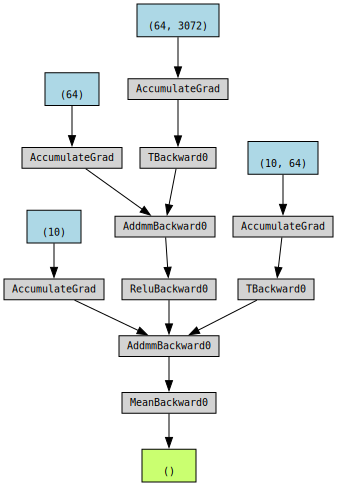

In [86]:
from torchviz import make_dot

# Linear layer
model = Net()
y = model(inputs)

make_dot(y.mean(), params=dict(net.named_parameters()))#,show_attrs=True, show_saved=True)

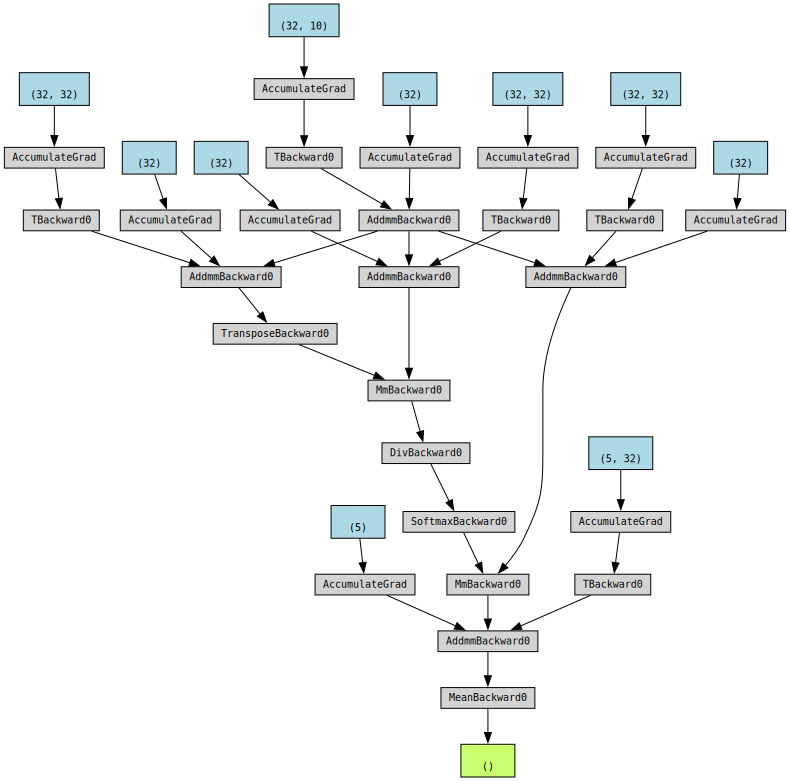

In [14]:
# Attention
model = SelfAttentionNet(input_dim=10, hidden_dim=32, output_dim=5)

input_data = torch.randn(16, 10)

output = model(input_data)

make_dot(output.mean(), params=dict(net.named_parameters()))#,show_attrs=True, show_saved=True)

### tensorboard

In [109]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
model = Net()
writer.add_graph(model, inputs)
writer.close()

In [16]:
model = SelfAttentionNet(input_dim=10, hidden_dim=32, output_dim=5)
input_data = torch.randn(16, 10)

writer = SummaryWriter("torchlogs_attention/")
writer.add_graph(model, input_data)
writer.close()

/var/folders/l9/br0sz1s10m31p2bp_kmsnkw00000gn/T/ipykernel_19836/421030764.py:17: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  attention_scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.shape[-1]))
/var/folders/l9/br0sz1s10m31p2bp_kmsnkw00000gn/T/ipykernel_19836/421030764.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.shape[-1]))


### netron

In [15]:
input_names = ["input"]
output_names = ["ouput"]

torch.onnx.export(model, inputs, "model.onnx", input_names=input_names, output_names=output_names)

NameError: name 'model' is not defined

In [20]:
input_names = ["input"]
output_names = ["output"]

model = SelfAttentionNet(input_dim=10, hidden_dim=32, output_dim=5)
input_data = torch.randn(16, 10)

torch.onnx.export(model, input_data, "model_attention.onnx", input_names=input_names, output_names=output_names)

/var/folders/l9/br0sz1s10m31p2bp_kmsnkw00000gn/T/ipykernel_87234/421030764.py:17: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  attention_scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.shape[-1]))
/var/folders/l9/br0sz1s10m31p2bp_kmsnkw00000gn/T/ipykernel_87234/421030764.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.shape[-1]))


In [110]:
input_names = ["cifar_100"]
output_names = ["output"]

torch.onnx.export(net, inputs, "mlp_cifar_100.onnx", input_names=input_names, output_names=output_names)